In [1]:
import os
import cv2

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

from skimage.io import imread
from skimage.transform import resize
from PIL import Image
#from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from keras.utils import np_utils

#from keras.models import *
#from keras.layers import *
#from keras.optimizers import *
#from keras.utils import *
#from keras.callbacks import *

#from keras.applications.densenet import DenseNet121, preprocess_input


- https://stackabuse.com/image-recognition-in-python-with-tensorflow-and-keras/
- https://blog.dominodatalab.com/feature-extraction-and-image-classification-using-deep-neural-networks
- https://github.com/bnsreenu/python_for_image_processing_APEER/blob/master/tutorial83_feature_extraction_RF_classification_V2.0.py
- https://www.kaggle.com/code/pierre54/bag-of-words-model-with-sift-descriptors/notebook
- https://www.kaggle.com/code/hengzheng/dog-breeds-classifier

In [3]:
folder_list = os.listdir("data/Images/")

num_classes = len(folder_list)
print("{} breeds".format(num_classes))

n_total_images = 0
for folder in folder_list:
    n_total_images += len(os.listdir("data/Images//{}".format(folder)))
print("{} images".format(n_total_images))

120 breeds
20581 images


In [4]:
def show_dir_images(Imagefolder,breed_folder, n_to_show):
    plt.figure(figsize=(16,16))
    img_dir = "{}/{}/".format(Imagefolder,breed_folder)
    images = os.listdir(img_dir)[:n_to_show]
    for i in range(n_to_show):
        img = mpimg.imread(img_dir + images[i])
        plt.subplot(n_to_show/4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')

n02085620-Chihuahua


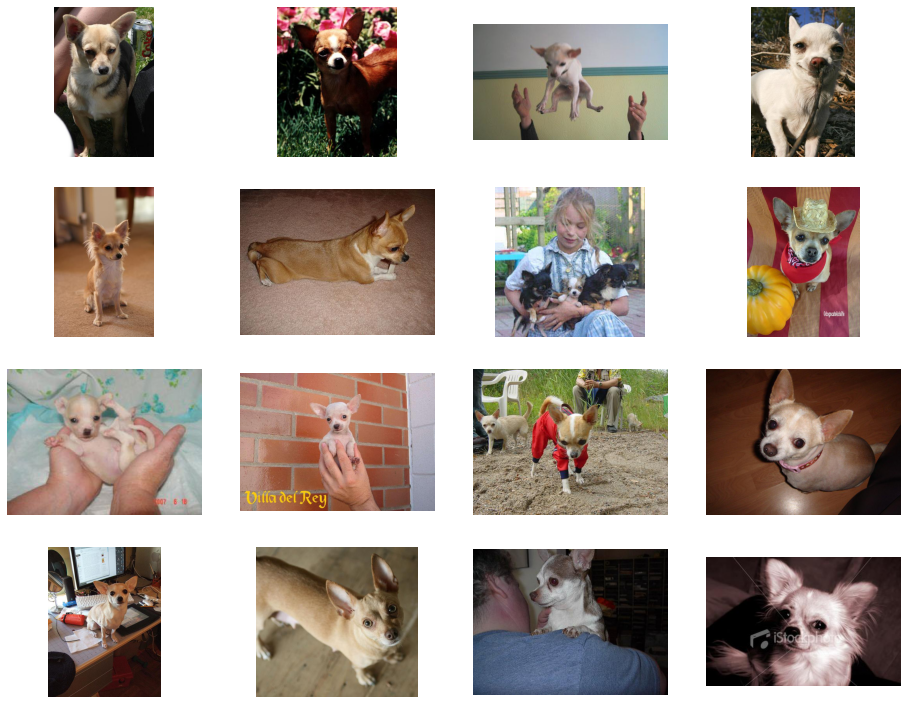

In [87]:
print(folder_list[0])
show_dir_images('data/Images',folder_list[0], 16)

In [88]:
%%time

# copy from https://www.kaggle.com/gabrielloye/dogs-inception-pytorch-implementation
# reduce the background noise

os.mkdir('data/Images-cropped')
for folder in folder_list:
    breed = '-'.join(folder.split('-')[1:])
    os.mkdir('data/Images-cropped/' + breed)
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data/Images-cropped'))))

for folder in folder_list:
    breed = '-'.join(folder.split('-')[1:])
    for file in os.listdir('data/Annotation/{}'.format(folder)):
        img = Image.open('data/Images/{}/{}.jpg'.format(folder, file))
        tree = ET.parse('data/Annotation/{}/{}'.format(folder, file))
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert('RGB')
        img = img.resize((128, 128))
        img.save('data/Images-cropped/' + breed + '/' + file + '.jpg')
        

Created 120 folders to store cropped images of the different breeds.
Wall time: 3min 43s


In [5]:
breed_list = os.listdir("data/Images-cropped")
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

In [6]:
def paths_and_labels():
    paths = list()
    labels = list()
    targets = list()
    for breed in breed_list:
        base_name = "./data/Images-cropped/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths, labels, targets = paths_and_labels()

assert len(paths) == len(labels)
assert len(paths) == len(targets)

targets = np_utils.to_categorical(targets, num_classes=num_classes)

black-and-tan_coonhound


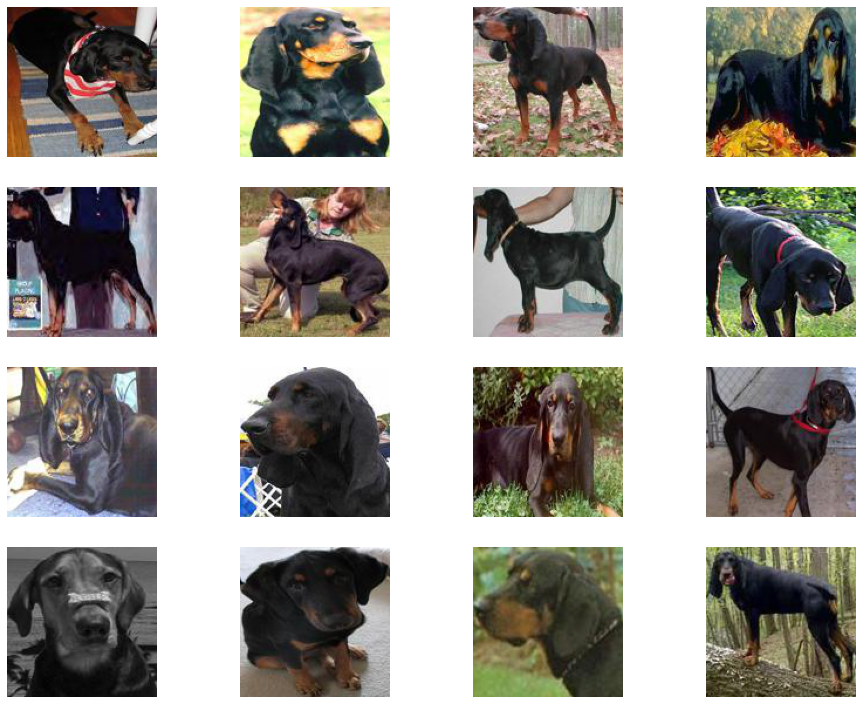

In [95]:
print(breed_list[12])
show_dir_images('data/Images-cropped',breed_list[12], 16)

# Création des features

In [6]:
from sklearn import preprocessing
def LoadImages(nbBreedToRead, nbToRead, nbToTest, cv2Method ) :
    list_images_train = []
    list_images_test = []
    labels_train_light = []
    labels_test_light = []
    for breed in breed_list[:nbBreedToRead]:
        img_dir = "./data/Images-cropped/{}/".format(breed)
        images = os.listdir(img_dir)[:nbToRead+nbToTest]
        for i in range(nbToRead):
            img = cv2.imread(img_dir + images[i], cv2Method)
            list_images_train.append(img)
            labels_train_light.append(breed)
        for i in range(nbToRead, nbToTest + nbToRead) :
            img =  cv2.imread(img_dir + images[i], cv2Method)
            list_images_test.append(img)
            labels_test_light.append(breed)
    list_images_train = np.array(list_images_train)
    list_images_test = np.array(list_images_test)
    le = preprocessing.LabelEncoder()
    le.fit(labels_train_light)
    labels_encoded = le.transform(labels_train_light)
    
    return list_images_train, list_images_test, labels_train_light, labels_test_light, labels_encoded, le

In [7]:
list_images_train, list_images_test, labels_train_light, labels_test_light, labels_encoded, le = LoadImages(10, 80, 10, cv2.IMREAD_COLOR )

In [8]:
# Normalize pixel values to between 0 and 1
list_images_train = list_images_train.astype('float32')/ 255.0

In [108]:
def feature_extractor(dataset, loadgray = 0 , gab = 0 ) :
    x_train = dataset
    image_dataset = pd.DataFrame()
    for image in range(x_train.shape[0]):  #iterate through each file 
        #print(image)
        
        df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.
        
        input_img = x_train[image, :,:,:]
        img = input_img
    ################################################################
    #START ADDING DATA TO THE DATAFRAME
    #Add feature extractors, e.g. edge detection, smoothing, etc. 
            
         # FEATURE 1 - Pixel values
         
        #Add pixel values to the data frame
        if loadgray == 0 : 
            pixel_values = img.reshape(-1)  
        else :
            img32 = np.float32(img)
            gray = cv2.cvtColor(img32, cv2.COLOR_BGR2GRAY)
            pixel_values = gray.reshape(-1)
            
        df['Pixel_Value'] = pixel_values #Pixel value itself as a feature
        
        # FEATURE 2 - Bunch of Gabor filter responses
        
                #Generate Gabor features
        if gab == 1 : 
            num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
            kernels = []
            for theta in range(2):   #Define number of thetas
                theta = theta / 4. * np.pi
                for sigma in (1, 3):  #Sigma with 1 and 3
                    lamda = np.pi/4
                    gamma = 0.5
                    gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
                    #print(gabor_label)
                    ksize=9
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                    kernels.append(kernel)
                    #Now filter the image and add values to a new column 
                    fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                    filtered_img = fimg.reshape(-1)
                    df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                    num += 1  #Increment for gabor column label            
            
        # FEATURE 3 Sobel
#        edge_sobel = sobel(img)
#        edge_sobel1 = edge_sobel.reshape(-1)
#        df['Sobel'] = edge_sobel1
       
        #Add more filters as needed
        
        #Append features from current image to the dataset
        image_dataset = image_dataset.append(df)
        
    return image_dataset
####################################################################

Utilisation des pixels en couleurs

In [10]:
#Extract features from training images
image_features = feature_extractor(list_images_train)

In [11]:
n_features = image_features.shape[1]
image_features = np.expand_dims(image_features, axis=0)
X_for_RF = np.reshape(image_features, (list_images_train.shape[0], -1))  #Reshape to #images, features

In [12]:
X_for_RF.shape

(800, 49152)

In [13]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [14]:
sc = StandardScaler()
Z = sc.fit_transform(X_for_RF)

In [15]:
acp = PCA(svd_solver='full',n_components = 2)
coord = acp.fit_transform(X_for_RF)
print(np.cumsum(acp.explained_variance_ratio_))
print(acp.explained_variance_ratio_.sum())

[0.14977921 0.24440149]
0.24440149146748116


In [16]:
import plotly.express as px

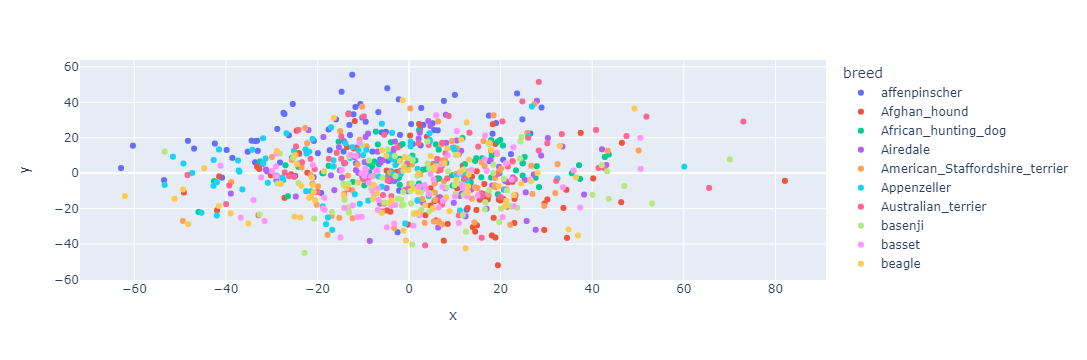

In [17]:
x=coord[:,0]
y=coord[:,1]
fig = px.scatter( x=x, y=y, text= labels_train_light , color = labels_train_light
                 , labels={'color':'breed', 'title' : 'ACP'})
fig.update_traces(
    mode='markers',
    marker={'sizemode':'area',
            'sizeref':10})
fig.show()

In [18]:
#Define the classifier
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 200, random_state = 42)

In [19]:
RF_model.fit(X_for_RF,labels_encoded)

RandomForestClassifier(n_estimators=200, random_state=42)

In [20]:
list_images_test_scaled = list_images_test.astype('float32') / 255.0
image_features = feature_extractor(list_images_test_scaled)
n_features = image_features.shape[1]
image_features = np.expand_dims(image_features, axis=0)
X_test = np.reshape(image_features, (list_images_test.shape[0], -1))  #Reshape to #images, features

In [68]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import metrics

In [22]:
y_prediction = RF_model.predict(X_test)

y_prediction = le.inverse_transform(y_prediction)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(labels_test_light, y_prediction))

Accuracy =  0.4


In [23]:
cm = confusion_matrix(labels_test_light, y_prediction)

In [24]:
print(classification_report(labels_test_light, y_prediction))

                                precision    recall  f1-score   support

                  Afghan_hound       0.30      0.30      0.30        10
           African_hunting_dog       0.38      0.50      0.43        10
                      Airedale       0.57      0.40      0.47        10
American_Staffordshire_terrier       0.25      0.20      0.22        10
                   Appenzeller       0.39      0.90      0.55        10
            Australian_terrier       0.50      0.20      0.29        10
                 affenpinscher       0.67      0.80      0.73        10
                       basenji       0.33      0.30      0.32        10
                        basset       1.00      0.10      0.18        10
                        beagle       0.23      0.30      0.26        10

                      accuracy                           0.40       100
                     macro avg       0.46      0.40      0.37       100
                  weighted avg       0.46      0.40      0.37 

<AxesSubplot:>

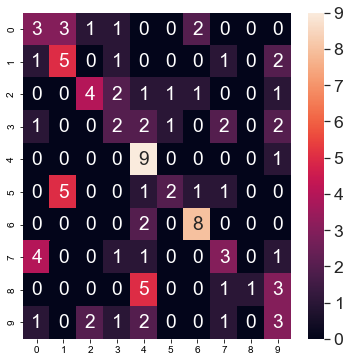

In [25]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, ax=ax)

The prediction for this image is:  beagle
The actual label for this image is:  basset


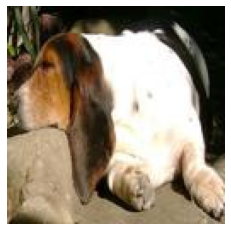

In [26]:
#Check results on a few random images
import random
n=random.randint(0, len(list_images_test)) #Select the index of image to be loaded for testing
img = list_images_test[n] #Reading color images
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.axis('off')

img = img/255.

#Extract features and reshape to right dimensions
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=feature_extractor(input_img)
input_img_features = np.expand_dims(input_img_features, axis=0)
input_img_for_RF = np.reshape(input_img_features, (input_img.shape[0], -1))
#Predict
img_prediction = RF_model.predict(input_img_for_RF)
img_prediction = le.inverse_transform([img_prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", img_prediction[0])
print("The actual label for this image is: ", labels_test_light[n])

In [27]:
import random
def show_pred_images(list_images_test, label_test, RF_model, test_feature, n_to_show):
    plt.figure(figsize=(20,25))
    for i in range(n_to_show):
        n=random.randint(0, len(list_images_test)-1)
        img = list_images_test[n]
        plt.subplot(n_to_show/3+1, 3, i+1)
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        img_prediction = RF_model.predict([test_feature[n]])
        img_prediction = le.inverse_transform([img_prediction])  #
        #plt.title('P/R : {}/{}'.format(img_prediction,labels_test_light[n]))
        msg = 'Real :' + label_test[n] + '\nPred :' +img_prediction[0]
        plt.title(msg)
        #plt.xlabel('P: ' + img_prediction[0])
        #plt.ylabel('R: ' + label_test[n])
        plt.axis('off')

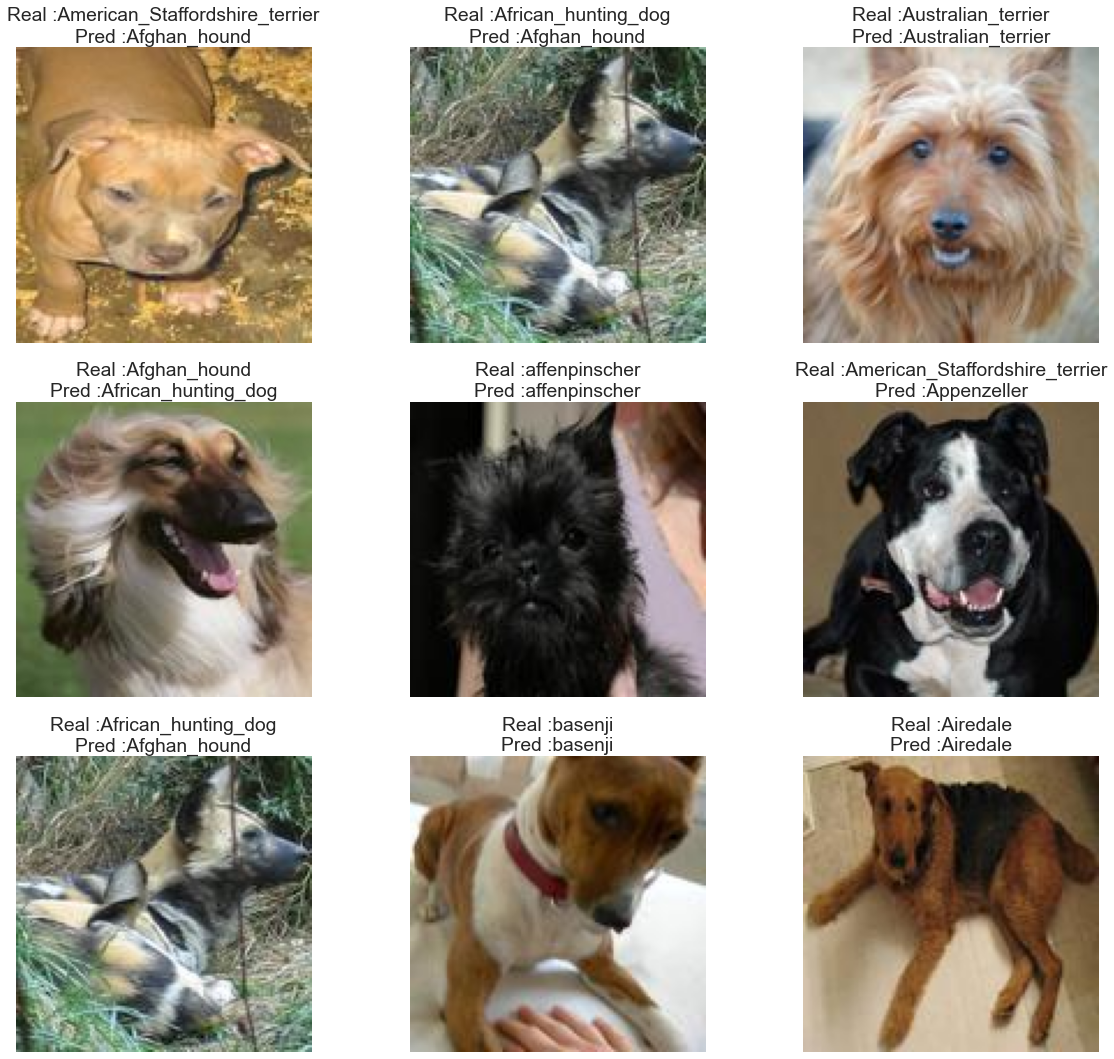

In [130]:
show_pred_images(list_images_test, labels_test_light, RF_model, X_test, 9)

Utilisation des pixels en noir et blanc

In [28]:
#Extract features from training images
image_features = feature_extractor(list_images_train,1)

In [29]:
n_features = image_features.shape[1]
image_features = np.expand_dims(image_features, axis=0)
X_for_RF = np.reshape(image_features, (list_images_train.shape[0], -1))  #Reshape to #images, features

In [30]:
X_for_RF.shape

(800, 16384)

In [31]:
#Define the classifier
from sklearn.ensemble import RandomForestClassifier
RF_model_gray = RandomForestClassifier(n_estimators = 200, random_state = 42)
RF_model_gray.fit(X_for_RF,labels_encoded)

RandomForestClassifier(n_estimators=200, random_state=42)

In [32]:
list_images_test_scaled = list_images_test / 255.0
image_features = feature_extractor(list_images_test_scaled,1)
n_features = image_features.shape[1]
image_features = np.expand_dims(image_features, axis=0)
X_test = np.reshape(image_features, (list_images_test.shape[0], -1))  #Reshape to #images, features
#labels_test_encoded = le.transform(labels_test_light)

In [33]:
y_prediction = RF_model_gray.predict(X_test)

y_prediction = le.inverse_transform(y_prediction)

#test_labels =  le.inverse_transform(y_test)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(labels_test_light, y_prediction))

Accuracy =  0.34


In [34]:
cm = confusion_matrix(labels_test_light, y_prediction)

In [35]:
print(classification_report(labels_test_light, y_prediction))

                                precision    recall  f1-score   support

                  Afghan_hound       0.36      0.40      0.38        10
           African_hunting_dog       0.31      0.40      0.35        10
                      Airedale       0.18      0.20      0.19        10
American_Staffordshire_terrier       0.00      0.00      0.00        10
                   Appenzeller       0.40      0.80      0.53        10
            Australian_terrier       0.33      0.30      0.32        10
                 affenpinscher       0.75      0.90      0.82        10
                       basenji       0.33      0.20      0.25        10
                        basset       0.20      0.10      0.13        10
                        beagle       0.14      0.10      0.12        10

                      accuracy                           0.34       100
                     macro avg       0.30      0.34      0.31       100
                  weighted avg       0.30      0.34      0.31 

<AxesSubplot:>

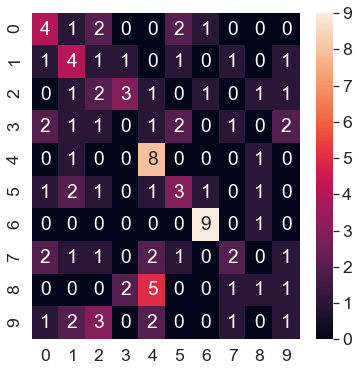

In [36]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, ax=ax)

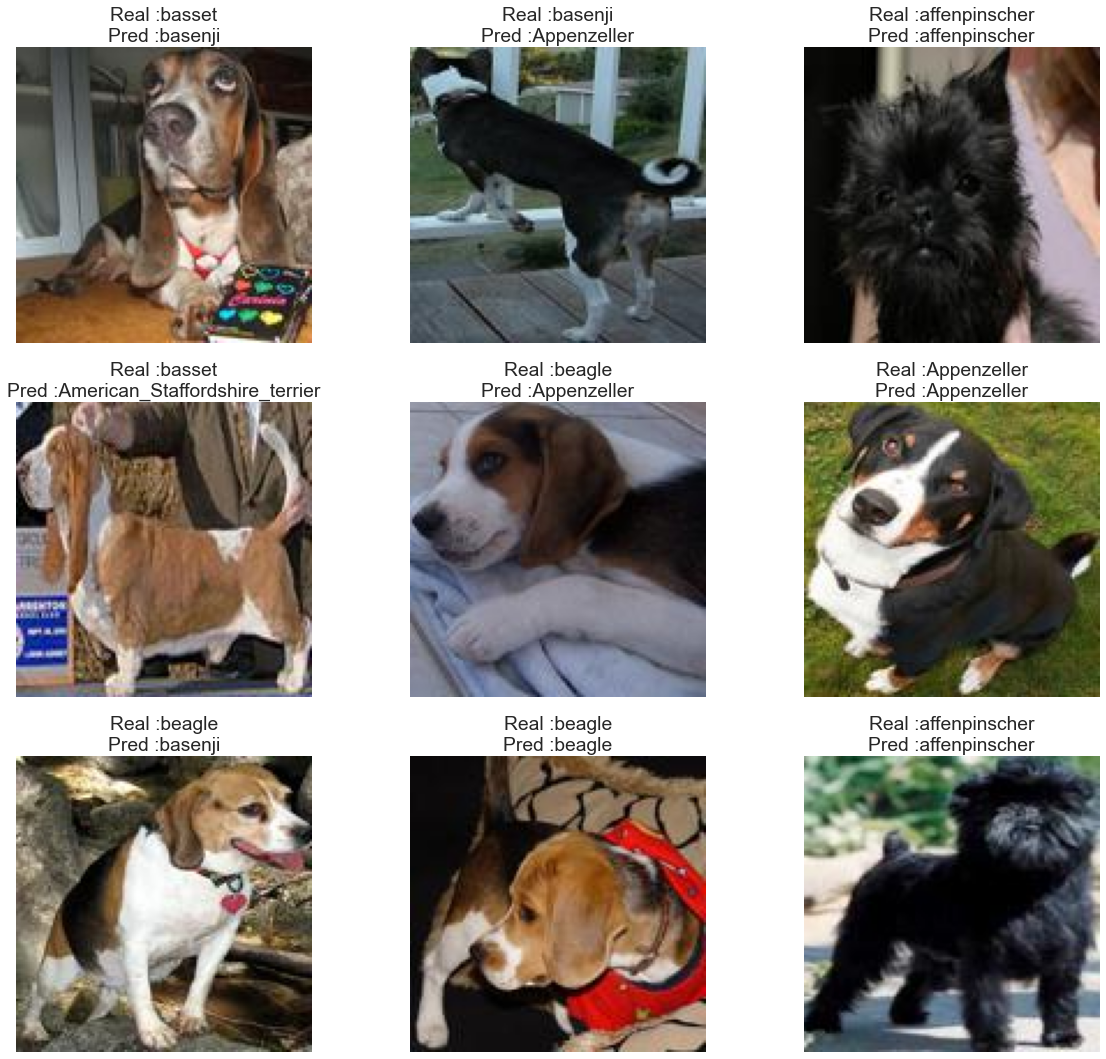

In [140]:
show_pred_images(list_images_test, labels_test_light, RF_model_gray,X_test, 9)

# SIFT Bag of words

- https://github.com/gurkandemir/Bag-of-Visual-Words/blob/df6080dec5fe227ffb1d7e47403b58401891882e/Code%20Files/BoW.py#L29
- https://github.com/Akhilesh64/Image-Classification-using-SIFT/blob/main/main.py

In [37]:
list_images_train, list_images_test, labels_train_light, labels_test_light, labels_encoded, le = LoadImages(10, 80, 10, cv2.IMREAD_COLOR)

In [38]:
# Create feature extraction and keypoint detector objects
def features(image, extractor):
    keypoints, descriptors = extractor.detectAndCompute(image, None)
    return keypoints, descriptors

# Return List where all the descriptors will be stored
def getDescriptorList(list_images, extractor):
    des_list = []
    for img in list_images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kpts, des = features(gray, extractor)
        des_list.append(des)  
    return des_list

# Stack all the descriptors vertically in a numpy array
def getVerticalDescriptors(des_list):
    descriptors = np.array(des_list[0])
    for descriptor in des_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 
    return descriptors

In [39]:
import cv2
import numpy as np

#BRISK is a good replacement to SIFT. ORB also works but didn;t work well for this example
#brisk = cv2.BRISK_create(30)
extractor = cv2.SIFT_create()

des_list = getDescriptorList(list_images_train,extractor)
des_list_test = getDescriptorList(list_images_test,extractor)

descriptors = getVerticalDescriptors(des_list)

#kmeans works only on float, so convert integers to float
descriptors_float = descriptors.astype(float) 
  

In [40]:
%%time
# Perform k-means clustering and vector quantization
from scipy.cluster.vq import kmeans, vq

k = 300  #k means with 100 clusters gives lower accuracy for the aeroplane example
voc, variance = kmeans(descriptors_float, k, 1) 

# Calculate the histogram of features and represent them as vector
#vq Assigns codes from a code book to observations.
im_features = np.zeros((len(list_images_train), k), "float32")
for i in range(len(list_images_train)) :
    words, distance = vq(des_list[i],voc)
    for w in words:
        im_features[i][w] += 1
        
# Calculate the histogram of features and represent them as vector
#vq Assigns codes from a code book to observations.
im_features_test = np.zeros((len(list_images_test), k), "float32")
for i in range(len(list_images_test)) :
    words, distance = vq(des_list_test[i],voc)
    for w in words:
        im_features_test[i][w] += 1

Wall time: 3min 40s


In [41]:
# Scaling the words
#Standardize features by removing the mean and scaling to unit variance
#In a way normalization
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)
im_features_test = stdSlr.transform(im_features_test)

In [42]:
#Train an algorithm to discriminate vectors corresponding to positive and negative training images
# Train the Linear SVM
#from sklearn.svm import LinearSVC
#clf = LinearSVC(max_iter=500)  #Default of 100 is not converging
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100, random_state=30)
clf.fit(im_features, labels_encoded)

RandomForestClassifier(random_state=30)

In [43]:
y_prediction = clf.predict(im_features_test)

y_prediction = le.inverse_transform(y_prediction)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(labels_test_light, y_prediction))

Accuracy =  0.16


In [44]:
cm = confusion_matrix(labels_test_light, y_prediction)

In [45]:
print(classification_report(labels_test_light, y_prediction))

                                precision    recall  f1-score   support

                  Afghan_hound       0.06      0.10      0.07        10
           African_hunting_dog       0.42      0.50      0.45        10
                      Airedale       0.12      0.10      0.11        10
American_Staffordshire_terrier       0.10      0.10      0.10        10
                   Appenzeller       0.00      0.00      0.00        10
            Australian_terrier       0.00      0.00      0.00        10
                 affenpinscher       0.17      0.30      0.21        10
                       basenji       0.33      0.20      0.25        10
                        basset       0.20      0.20      0.20        10
                        beagle       0.11      0.10      0.11        10

                      accuracy                           0.16       100
                     macro avg       0.15      0.16      0.15       100
                  weighted avg       0.15      0.16      0.15 

<AxesSubplot:>

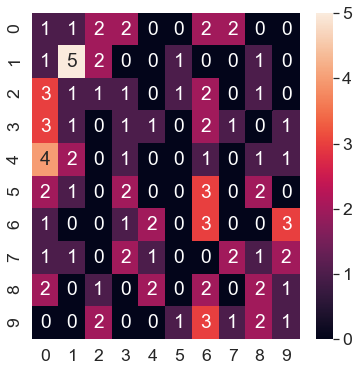

In [46]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, ax=ax)

In [169]:
show_pred_images(list_images_test, labels_test_light , clf, test_features,  9)

NameError: name 'show_pred_images' is not defined

# ORB

In [47]:
import cv2
import numpy as np

#BRISK is a good replacement to SIFT. ORB also works but didn;t work well for this example
#brisk = cv2.BRISK_create(30)
extractor = cv2.ORB_create()

des_list = getDescriptorList(list_images_train,extractor)
des_list_test = getDescriptorList(list_images_test,extractor)

descriptors = getVerticalDescriptors(des_list)

#kmeans works only on float, so convert integers to float
descriptors_float = descriptors.astype(float) 
  

In [48]:
%%time
# Perform k-means clustering and vector quantization
from scipy.cluster.vq import kmeans, vq

k = 300  #k means with 100 clusters gives lower accuracy for the aeroplane example
voc, variance = kmeans(descriptors_float, k, 1) 

# Calculate the histogram of features and represent them as vector
#vq Assigns codes from a code book to observations.
im_features = np.zeros((len(list_images_train), k), "float32")
for i in range(len(list_images_train)) :
    words, distance = vq(des_list[i],voc)
    for w in words:
        im_features[i][w] += 1
        
# Calculate the histogram of features and represent them as vector
#vq Assigns codes from a code book to observations.
im_features_test = np.zeros((len(list_images_test), k), "float32")
for i in range(len(list_images_test)) :
    words, distance = vq(des_list_test[i],voc)
    for w in words:
        im_features_test[i][w] += 1

Wall time: 2min 1s


In [49]:
# Scaling the words
#Standardize features by removing the mean and scaling to unit variance
#In a way normalization
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)
im_features_test = stdSlr.transform(im_features_test)

In [50]:
#Train an algorithm to discriminate vectors corresponding to positive and negative training images
# Train the Linear SVM
#from sklearn.svm import LinearSVC
#clf = LinearSVC(max_iter=1000)  #Default of 100 is not converging
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100, random_state=30)
clf.fit(im_features, labels_encoded)

RandomForestClassifier(random_state=30)

In [51]:
y_prediction = clf.predict(im_features_test)

y_prediction = le.inverse_transform(y_prediction)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(labels_test_light, y_prediction))

Accuracy =  0.2


In [52]:
cm = confusion_matrix(labels_test_light, y_prediction)

In [53]:
print(classification_report(labels_test_light, y_prediction))

                                precision    recall  f1-score   support

                  Afghan_hound       0.19      0.40      0.26        10
           African_hunting_dog       0.39      0.70      0.50        10
                      Airedale       0.08      0.10      0.09        10
American_Staffordshire_terrier       0.00      0.00      0.00        10
                   Appenzeller       0.33      0.40      0.36        10
            Australian_terrier       0.00      0.00      0.00        10
                 affenpinscher       0.29      0.20      0.24        10
                       basenji       0.22      0.20      0.21        10
                        basset       0.00      0.00      0.00        10
                        beagle       0.00      0.00      0.00        10

                      accuracy                           0.20       100
                     macro avg       0.15      0.20      0.17       100
                  weighted avg       0.15      0.20      0.17 

<AxesSubplot:>

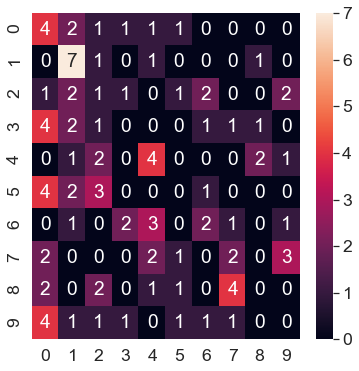

In [54]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, ax=ax)

# BRISK

In [55]:
import cv2
import numpy as np

#BRISK is a good replacement to SIFT. ORB also works but didn;t work well for this example
#brisk = cv2.BRISK_create(30)
extractor = cv2.BRISK_create()

des_list = getDescriptorList(list_images_train,extractor)
des_list_test = getDescriptorList(list_images_test,extractor)

descriptors = getVerticalDescriptors(des_list)

#kmeans works only on float, so convert integers to float
descriptors_float = descriptors.astype(float) 
  

In [56]:
%%time
# Perform k-means clustering and vector quantization
from scipy.cluster.vq import kmeans, vq

k = 300  #k means with 100 clusters gives lower accuracy for the aeroplane example
voc, variance = kmeans(descriptors_float, k, 1) 

# Calculate the histogram of features and represent them as vector
#vq Assigns codes from a code book to observations.
im_features = np.zeros((len(list_images_train), k), "float32")
for i in range(len(list_images_train)) :
    words, distance = vq(des_list[i],voc)
    for w in words:
        im_features[i][w] += 1
        
# Calculate the histogram of features and represent them as vector
#vq Assigns codes from a code book to observations.
im_features_test = np.zeros((len(list_images_test), k), "float32")
for i in range(len(list_images_test)) :
    words, distance = vq(des_list_test[i],voc)
    for w in words:
        im_features_test[i][w] += 1

Wall time: 3min 12s


In [57]:
# Scaling the words
#Standardize features by removing the mean and scaling to unit variance
#In a way normalization
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)
im_features_test = stdSlr.transform(im_features_test)

In [58]:
#Train an algorithm to discriminate vectors corresponding to positive and negative training images
# Train the Linear SVM
#from sklearn.svm import LinearSVC
#clf = LinearSVC(max_iter=1000)  #Default of 100 is not converging
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100, random_state=30)
clf.fit(im_features, labels_encoded)

RandomForestClassifier(random_state=30)

In [59]:
y_prediction = clf.predict(im_features_test)

y_prediction = le.inverse_transform(y_prediction)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(labels_test_light, y_prediction))

Accuracy =  0.18


In [60]:
cm = confusion_matrix(labels_test_light, y_prediction)

In [61]:
print(classification_report(labels_test_light, y_prediction))

                                precision    recall  f1-score   support

                  Afghan_hound       0.12      0.20      0.15        10
           African_hunting_dog       0.37      0.70      0.48        10
                      Airedale       0.00      0.00      0.00        10
American_Staffordshire_terrier       0.29      0.20      0.24        10
                   Appenzeller       0.00      0.00      0.00        10
            Australian_terrier       0.08      0.10      0.09        10
                 affenpinscher       0.29      0.40      0.33        10
                       basenji       0.17      0.10      0.12        10
                        basset       0.33      0.10      0.15        10
                        beagle       0.00      0.00      0.00        10

                      accuracy                           0.18       100
                     macro avg       0.16      0.18      0.16       100
                  weighted avg       0.16      0.18      0.16 

<AxesSubplot:>

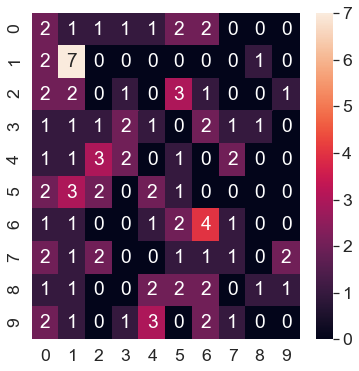

In [62]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, ax=ax)

################################################ 

In [13]:
batch_size = 64

class ImageGenerator(Sequence):
    
    def __init__(self, paths, targets, batch_size, shape, augment=False):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
        self.augment = augment
        
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        x = np.zeros((len(batch_paths), self.shape[0], self.shape[1], self.shape[2]), dtype=np.float32)
        y = np.zeros((self.batch_size, num_classes, 1))
        for i, path in enumerate(batch_paths):
            x[i] = self.__load_image(path)
        y = self.targets[idx * self.batch_size : (idx + 1) * self.batch_size]
        return x, y
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image = imread(path)
        image = preprocess_input(image)
        if self.augment:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.CropAndPad(percent=(-0.25, 0.25)),
                    iaa.Crop(percent=(0, 0.1)),
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])
            ], random_order=True)
            image = seq.augment_image(image)
        return image

In [14]:
train_paths, val_paths, train_targets, val_targets = train_test_split(paths, 
                                                  targets,
                                                  test_size=0.15, 
                                                  random_state=1029)

train_gen = ImageGenerator(train_paths, train_targets, batch_size=32, shape=(224,224,3), augment=True)
val_gen = ImageGenerator(val_paths, val_targets, batch_size=32, shape=(224,224,3), augment=False)

In [ ]:
inp = Input((224, 224, 3))
backbone = DenseNet121(input_tensor=inp,
                       weights="../input/densenet-keras/DenseNet-BC-121-32-no-top.h5",
                       include_top=False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outp = Dense(num_classes, activation="softmax")(x)

model = Model(inp, outp)

######################################################################################

https://github.com/denizn/Dog-Breed-Classifier/blob/master/dog_app.ipynb

In [2]:
from sklearn import preprocessing
from keras.preprocessing import image
from tqdm import tqdm

def ReadImage(img_path,lib, cv2Method) :
    if lib == 'cv2' :
        return cv2.imread(img_path, cv2Method)
    else :
        # loads RGB image as PIL.Image.Image type
        img = image.load_img(img_path, target_size=(128, 128))
        # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
        x = image.img_to_array(img).astype('float32')/255
        # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
        return x

def LoadImages(nbBreedToRead, nbToRead, lib, cv2Method ) :
    list_images_train = []
    labels_train_light = []
    breed_list = os.listdir('./data/Images-cropped/')
    if ( nbBreedToRead == 0 ) :
        nbBreed = len(breed_list)
    else :
        nbBreed = nbBreedToRead
    for breed in tqdm(breed_list[:nbBreed]):
        img_dir = "./data/Images-cropped/{}/".format(breed)
        if (nbToRead == 0 ) : 
            nbDog = len(os.listdir(img_dir))
        else :
            nbDog = nbToRead
        images = os.listdir(img_dir)[:nbDog]
        for i in range(nbDog):
            img = ReadImage(img_dir + images[i],lib,cv2Method)
            list_images_train.append(img)
            labels_train_light.append(breed)
    list_images_train = np.array(list_images_train)
    le = preprocessing.LabelEncoder()
    le.fit(labels_train_light)
    labels_encoded_train = le.transform(labels_train_light)
    
    return list_images_train, labels_train_light, labels_encoded_train, le

In [3]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True   

list_images, labels_train, labels_encoded, le = LoadImages(10, 120, 'keras', '') 

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.35it/s]


In [5]:
train_tensors, valid_tensors, labels_train_encoded, labels_valid_encoded = train_test_split(list_images, labels_encoded, test_size=0.2, random_state=42)

In [6]:
train_tensors, test_tensors, labels_train_encoded, labels_test_encoded = train_test_split(train_tensors, labels_train_encoded, test_size=0.1, random_state=42)

In [7]:
print("Shape of train : {}".format(train_tensors.shape))
print("Shape of valid : {}".format(valid_tensors.shape))
print("Shape of test : {}".format(test_tensors.shape))

Shape of train : (864, 128, 128, 3)
Shape of valid : (240, 128, 128, 3)
Shape of test : (96, 128, 128, 3)


In [3]:
import os
#Disable GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [9]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(input_shape=train_tensors.shape[1:],filters=16,kernel_size=2, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=32,kernel_size=2, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=64,kernel_size=2, activation='relu'))
model.add(MaxPooling2D())
model.add(GlobalAveragePooling2D())
model.add(Dense(len(le.classes_),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0

In [10]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
%%time
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau 

### specify the number of epochs that you would like to use to train the model.
epochs = 50

checkpointer = ModelCheckpoint(filepath='weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

early_stopping = EarlyStopping(patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3,verbose=1)

model.fit(train_tensors, labels_train_encoded, 
          validation_data=(valid_tensors, labels_valid_encoded),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 2.3075 - accuracy: 0.0775
Epoch 1: val_loss improved from inf to 2.29017, saving model to weights.best.from_scratch.hdf5
44/44 [==============================] - 9s 154ms/step - loss: 2.3075 - accuracy: 0.0775 - val_loss: 2.2902 - val_accuracy: 0.1500
Epoch 2/50
43/44 [============================>.] - ETA: 0s - loss: 2.2902 - accuracy: 0.1174
Epoch 2: val_loss improved from 2.29017 to 2.26924, saving model to weights.best.from_scratch.hdf5
44/44 [==============================] - 7s 166ms/step - loss: 2.2904 - accuracy: 0.1169 - val_loss: 2.2692 - val_accuracy: 0.1167
Epoch 3/50
43/44 [============================>.] - ETA: 0s - loss: 2.2698 - accuracy: 0.1430
Epoch 3: val_loss improved from 2.26924 to 2.23017, saving model to weights.best.from_scratch.hdf5
44/44 [==============================] - 7s 166ms/step - loss: 2.2698 - accuracy: 0.1435 - val_loss: 2.2302 - val_accuracy: 0.1667
Epoch 4/50
43/44 [==============

In [12]:
y_prediction = np.argmax(model.predict(test_tensors), axis=1)

y_prediction = le.inverse_transform(y_prediction)

labels_test =  le.inverse_transform(labels_test_encoded)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(labels_test, y_prediction))

Accuracy =  0.3333333333333333


In [13]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(labels_test, y_prediction)

In [14]:
print(classification_report(labels_test, y_prediction))

                                precision    recall  f1-score   support

                  Afghan_hound       0.33      0.60      0.43         5
           African_hunting_dog       0.00      0.00      0.00         6
                      Airedale       0.00      0.00      0.00         8
American_Staffordshire_terrier       0.21      0.33      0.26         9
                   Appenzeller       0.44      0.31      0.36        13
            Australian_terrier       0.43      0.27      0.33        11
                 affenpinscher       0.48      0.93      0.64        15
                       basenji       0.25      0.17      0.20         6
                        basset       0.15      0.30      0.20        10
                        beagle       1.00      0.08      0.14        13

                      accuracy                           0.33        96
                     macro avg       0.33      0.30      0.26        96
                  weighted avg       0.39      0.33      0.29 

<AxesSubplot:>

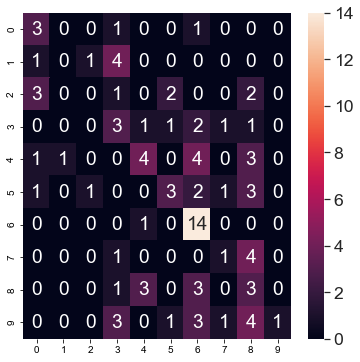

In [15]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, ax=ax)

https://www.kaggle.com/code/waterchiller/vgg16-classification-dog-breed/notebook

In [35]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
base_model=VGG16(weights='imagenet',include_top=False)

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(1024,activation='relu')(x)
x=Dropout(0.5)(x)
x=Dense(512,activation='relu')(x)
preds=Dense(len(le.classes_),activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=preds)

for layer in model.layers[:-5]:
    layer.trainable=False
for layer in model.layers[-5:]:
    layer.trainable=True
    
model.compile(optimizer='rmsprop',loss="sparse_categorical_crossentropy",metrics=["accuracy"])

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [36]:
%%time
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau 

### specify the number of epochs that you would like to use to train the model.
epochs = 50

checkpointer = ModelCheckpoint(filepath='weights.best.transfer_learning.hdf5', 
                               verbose=1, save_best_only=True)

early_stopping = EarlyStopping(patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3,verbose=1)

model.fit(train_tensors, labels_train_encoded, 
          validation_data=(valid_tensors, labels_valid_encoded),
          epochs=epochs, batch_size=20, callbacks=[checkpointer,early_stopping,reduce_lr], verbose=1)

Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 2.2402 - accuracy: 0.2350
Epoch 1: val_loss improved from inf to 1.74240, saving model to weights.best.transfer_learning.hdf5
44/44 [==============================] - 68s 2s/step - loss: 2.2402 - accuracy: 0.2350 - val_loss: 1.7424 - val_accuracy: 0.3708 - lr: 0.0010
Epoch 2/50
44/44 [==============================] - ETA: 0s - loss: 1.6465 - accuracy: 0.4236
Epoch 2: val_loss did not improve from 1.74240
44/44 [==============================] - 67s 2s/step - loss: 1.6465 - accuracy: 0.4236 - val_loss: 2.0320 - val_accuracy: 0.2917 - lr: 0.0010
Epoch 3/50
44/44 [==============================] - ETA: 0s - loss: 1.3469 - accuracy: 0.5150
Epoch 3: val_loss improved from 1.74240 to 1.46119, saving model to weights.best.transfer_learning.hdf5
44/44 [==============================] - 67s 2s/step - loss: 1.3469 - accuracy: 0.5150 - val_loss: 1.4612 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/50
44/44 [=======================

In [37]:
loss, acc = model.evaluate(valid_tensors,labels_valid_encoded,verbose=0)
print(f"loss on the test set is {loss:.2f}")
print(f"accuracy on the test set is {acc:.3f}")

loss on the test set is 0.77
accuracy on the test set is 0.758


In [38]:
y_prediction = np.argmax(model.predict(test_tensors), axis=1)

y_prediction = le.inverse_transform(y_prediction)

labels_test =  le.inverse_transform(labels_test_encoded)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(labels_test, y_prediction))

Accuracy =  0.7083333333333334


In [40]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(labels_test, y_prediction)

In [42]:
print(classification_report(labels_test, y_prediction))

                                precision    recall  f1-score   support

                  Afghan_hound       0.60      0.60      0.60         5
           African_hunting_dog       0.75      1.00      0.86         6
                      Airedale       0.67      0.50      0.57         8
American_Staffordshire_terrier       0.80      0.89      0.84         9
                   Appenzeller       0.77      0.77      0.77        13
            Australian_terrier       1.00      0.73      0.84        11
                 affenpinscher       0.76      0.87      0.81        15
                       basenji       0.83      0.83      0.83         6
                        basset       0.54      0.70      0.61        10
                        beagle       0.40      0.31      0.35        13

                      accuracy                           0.71        96
                     macro avg       0.71      0.72      0.71        96
                  weighted avg       0.71      0.71      0.70 

<AxesSubplot:>

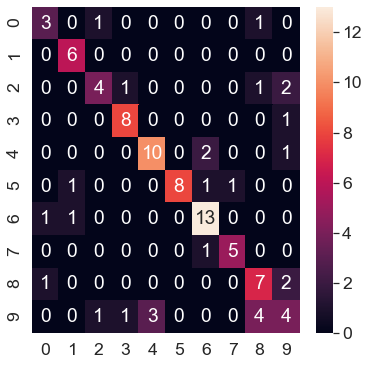

In [43]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, ax=ax)

###################################################

# Train all breeds and dataset

In [4]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

train_tensors, labels_train, labels_encoded, le = LoadImages(0, 0, 'keras', '')

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:36<00:00,  3.27it/s]


In [5]:
train_tensors, valid_tensors, labels_encoded_train, labels_valid_encoded = train_test_split(train_tensors, labels_encoded, test_size=0.2, random_state=42)

In [6]:
train_tensors, test_tensors, labels_encoded_train, labels_test_encoded = train_test_split(train_tensors, labels_encoded_train, test_size=0.1, random_state=42)

In [7]:
%%time
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

base_model=VGG16(weights='imagenet',include_top=False)

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(1024,activation='relu')(x)
x=Dropout(0.5)(x)
x=Dense(512,activation='relu')(x)
preds=Dense(len(le.classes_),activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=preds)

for layer in model.layers[:-5]:
    layer.trainable=False
for layer in model.layers[-5:]:
    layer.trainable=True
    
model.compile(optimizer='rmsprop',loss="sparse_categorical_crossentropy",metrics=["accuracy"])

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [8]:
%%time
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

### specify the number of epochs that you would like to use to train the model.
epochs = 20

checkpointer = ModelCheckpoint(filepath='weights.best.transfer_learning_full.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, labels_encoded_train, 
          validation_data=(valid_tensors, labels_valid_encoded),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20
741/741 [==============================] - ETA: 0s - loss: 4.1652 - accuracy: 0.0621
Epoch 1: val_loss improved from inf to 3.47120, saving model to weights.best.transfer_learning_full.hdf5
741/741 [==============================] - 1601s 2s/step - loss: 4.1652 - accuracy: 0.0621 - val_loss: 3.4712 - val_accuracy: 0.1363
Epoch 2/20
741/741 [==============================] - ETA: 0s - loss: 3.3703 - accuracy: 0.1583
Epoch 2: val_loss improved from 3.47120 to 3.13068, saving model to weights.best.transfer_learning_full.hdf5
741/741 [==============================] - 1486s 2s/step - loss: 3.3703 - accuracy: 0.1583 - val_loss: 3.1307 - val_accuracy: 0.2058
Epoch 3/20
741/741 [==============================] - ETA: 0s - loss: 3.1026 - accuracy: 0.2127
Epoch 3: val_loss improved from 3.13068 to 3.02162, saving model to weights.best.transfer_learning_full.hdf5
741/741 [==============================] - 1475s 2s/step - loss: 3.1026 - accuracy: 0.2127 - val_loss: 3.0216 - val_accurac

In [9]:
loss, acc = model.evaluate(valid_tensors,labels_valid_encoded,verbose=0)
print(f"loss on the test set is {loss:.2f}")
print(f"accuracy on the test set is {acc:.3f}")

loss on the test set is 3.20
accuracy on the test set is 0.264


In [10]:
y_prediction = np.argmax(model.predict(test_tensors), axis=1)

y_prediction = le.inverse_transform(y_prediction)

labels_test =  le.inverse_transform(labels_test_encoded)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(labels_test, y_prediction))

Accuracy =  0.24772313296903462


In [11]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(labels_test, y_prediction)

In [12]:
print(classification_report(labels_test, y_prediction))

                                precision    recall  f1-score   support

                  Afghan_hound       0.75      0.30      0.43        20
           African_hunting_dog       1.00      0.29      0.44        14
                      Airedale       0.08      0.06      0.07        17
American_Staffordshire_terrier       0.29      0.27      0.28        15
                   Appenzeller       0.29      0.57      0.38        14
            Australian_terrier       0.21      0.27      0.24        11
            Bedlington_terrier       0.52      0.76      0.62        17
          Bernese_mountain_dog       0.13      0.11      0.12        18
              Blenheim_spaniel       0.40      0.13      0.20        15
                 Border_collie       0.31      0.29      0.30        14
                Border_terrier       0.29      0.40      0.33        15
                   Boston_bull       0.50      0.21      0.30        14
          Bouvier_des_Flandres       0.00      0.00      0.00  

<AxesSubplot:>

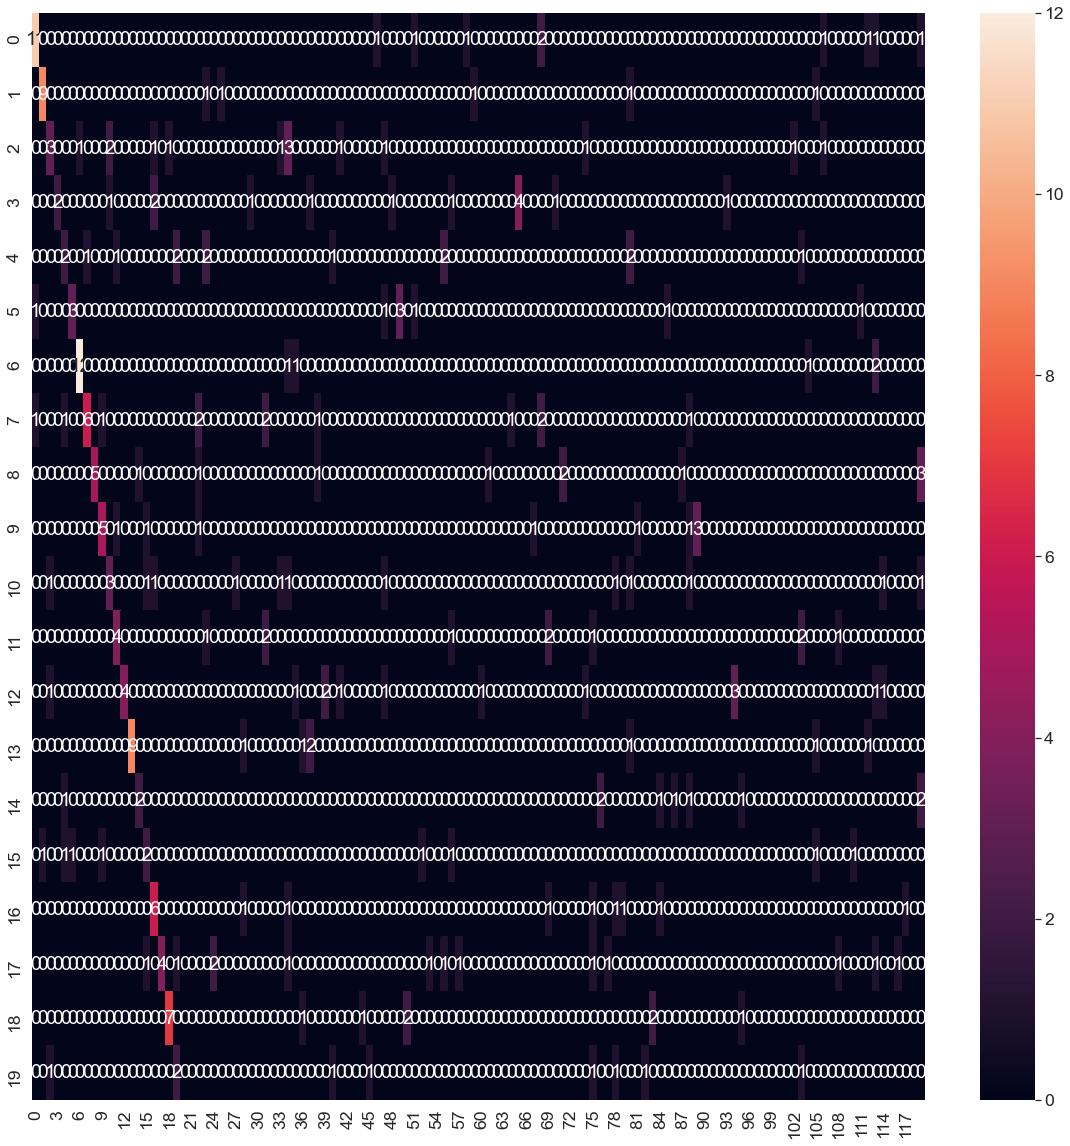

In [27]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm[:20][:20], annot=True, ax=ax)

In [41]:
cm[:2][:2][:2]

array([[11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
         0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
         1,  1,  0,  0,  0,  0,  0,  1],
       [ 0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,